In [1]:
from helper_functions import download_data
image_dir_path = download_data(
    source="https://github.com/harshankbansal/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
    destination="food_dataset"
)

d:\accounts\learning\ai\pytorch\udemy-zth\pytorch-deep-learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] data\food_dataset directory exists, skipping download.


## Reading images.

In [2]:
import glob
all_images_path = glob.glob(str(image_dir_path) + '/*/*/*.jpg')

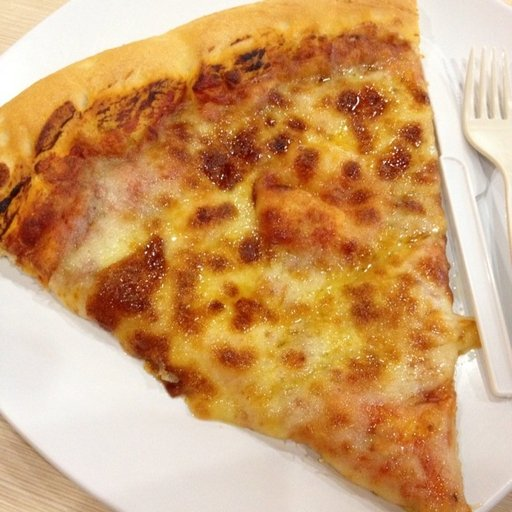

In [3]:
import numpy as np
from PIL import Image


random_image = Image.open(np.random.choice(all_images_path, 1)[0])
random_image

array([[[242, 220, 181],
        [241, 219, 180],
        [240, 218, 179],
        ...,
        [251, 226, 185],
        [255, 230, 187],
        [255, 232, 187]],

       [[243, 221, 182],
        [243, 221, 182],
        [242, 220, 181],
        ...,
        [254, 229, 189],
        [252, 227, 186],
        [248, 224, 180]],

       [[244, 222, 183],
        [244, 222, 183],
        [244, 222, 183],
        ...,
        [255, 232, 196],
        [252, 228, 190],
        [246, 223, 182]],

       ...,

       [[231, 203, 166],
        [233, 205, 168],
        [234, 206, 169],
        ...,
        [168, 137, 109],
        [170, 139, 111],
        [169, 138, 110]],

       [[226, 200, 163],
        [223, 197, 160],
        [225, 197, 160],
        ...,
        [170, 136, 108],
        [176, 142, 115],
        [180, 146, 119]],

       [[218, 192, 155],
        [219, 193, 156],
        [223, 195, 158],
        ...,
        [165, 131, 103],
        [174, 140, 113],
        [182, 148, 121]]

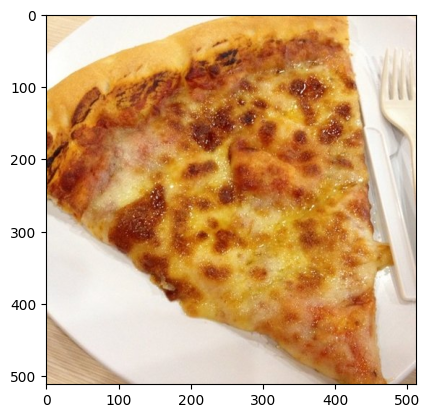

In [4]:
import matplotlib.pyplot as plt
img_as_np = np.asarray(random_image)

plt.imshow(img_as_np)
img_as_np

In [5]:
from torch import nn
from torchvision.transforms.functional import to_tensor

to_tensor(random_image).shape

torch.Size([3, 512, 512])

### Custom Dataset
The following custom class is not needed as torchvision provides an implementation `datasets.ImageFolder` for this kind of data structure 

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import ToTensor
from pathlib import Path
import os


class CustomImageDataset(Dataset):
    def __init__(self, root_path):
        super().__init__()
        self.root_path = str(root_path)
        self.root_path += ("" if self.root_path.endswith("/") else "/")
        self.class_names = os.listdir(root_path)
        self.class_names.sort()
        self.train_image_transforms = ToTensor()
        self.all_image_paths = glob.glob(self.root_path + '*/*.jpg')

    def __len__(self):
        return len(self.all_image_paths)
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError(f"Index out of range. Size = {len(self)}. Index Requested = {index}")
        
        img_path = Path(self.all_image_paths[index])
        label = img_path.parent.stem
        img = self.train_image_transforms(Image.open(img_path))
        return img, label

In [7]:
train_dataset = CustomImageDataset(image_dir_path / "train")
test_dataset = CustomImageDataset(image_dir_path / "test")

In [8]:
len(train_dataset), len(test_dataset)

(225, 75)

In [9]:
train_dataset.class_names, test_dataset.class_names

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

The above is not needed as we can use `torchvision.datasets.ImageFolder` like below

### Trying `datasets.ImageFolder` Dataset

In [10]:
from torchvision import datasets

ds = datasets.ImageFolder(image_dir_path / "train")
len(ds)

225

In [11]:
ds.classes

['pizza', 'steak', 'sushi']

### Creating image transformation script


In [ ]:
from torchvision import transforms
train_image_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
])

test_image_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [ ]:
img_as_tensor = train_image_transforms(random_image)
img_as_np = np.asarray(random_image)
img_as_tensor.shape, img_as_np.shape

(torch.Size([3, 64, 64]), (512, 512, 3))

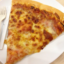

In [14]:
transforms.ToPILImage()(img_as_tensor)

#### Visualize transformation compared to original


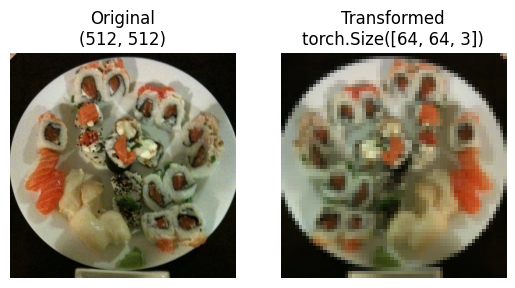

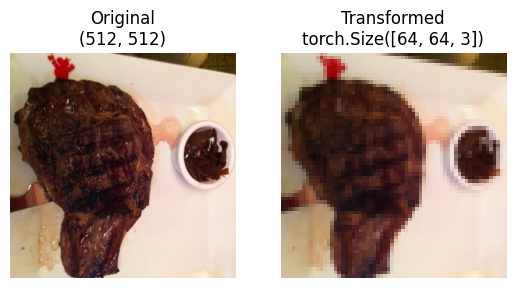

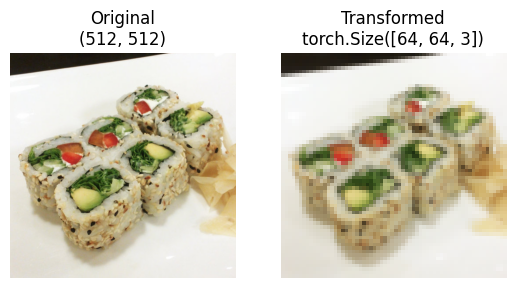

In [ ]:
import matplotlib.pyplot as plt
import random

def random_visualize_image_transformations(image_paths, img_tranforms, n=3):
    image_paths = random.sample(image_paths, k=n)
    for image_path in image_paths:
        image = Image.open(image_path)
        tranformed_image = img_tranforms(image).permute(1,2,0)
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].set_title(f"Original\n{image.size}")
        ax[0].imshow(image)
        ax[0].axis(False)
        
        ax[1].set_title(f"Transformed\n{tranformed_image.shape}")
        ax[1].imshow(tranformed_image)
        ax[1].axis(False)



random_visualize_image_transformations(all_images_path, train_image_transforms)


## Creating Dataset & DataLoader

In [16]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
train_dataset = datasets.ImageFolder(
    image_dir_path / "train", 
    transform=train_image_transforms
)
test_dataset = datasets.ImageFolder(
    image_dir_path / "test",
    transform=test_image_transforms
)
len(train_dataset), len(test_dataset)

(225, 75)

In [18]:
train_dataset.classes

['pizza', 'steak', 'sushi']

#### visualize an image from dataset

In [19]:
img, label = train_dataset[11]
img, train_dataset.classes[label]

(tensor([[[0.8196, 0.8078, 0.8157,  ..., 0.8745, 0.8745, 0.8745],
          [0.8392, 0.8235, 0.8118,  ..., 0.8824, 0.8863, 0.8784],
          [0.7843, 0.8392, 0.8157,  ..., 0.8902, 0.8863, 0.8784],
          ...,
          [0.3725, 0.3882, 0.3922,  ..., 0.2157, 0.1373, 0.1255],
          [0.3882, 0.3843, 0.3804,  ..., 0.2471, 0.1843, 0.1137],
          [0.4471, 0.4078, 0.3804,  ..., 0.2431, 0.2039, 0.1412]],
 
         [[0.5451, 0.5333, 0.5333,  ..., 0.6078, 0.6078, 0.6157],
          [0.5647, 0.5529, 0.5333,  ..., 0.6157, 0.6196, 0.6196],
          [0.5059, 0.5647, 0.5333,  ..., 0.6275, 0.6235, 0.6196],
          ...,
          [0.1725, 0.1804, 0.1765,  ..., 0.1059, 0.0706, 0.0706],
          [0.1804, 0.1804, 0.1725,  ..., 0.1255, 0.0941, 0.0667],
          [0.2039, 0.1882, 0.1725,  ..., 0.1137, 0.1020, 0.0784]],
 
         [[0.0157, 0.0039, 0.0078,  ..., 0.0000, 0.0039, 0.0078],
          [0.0431, 0.0196, 0.0039,  ..., 0.0039, 0.0078, 0.0078],
          [0.0196, 0.0392, 0.0039,  ...,

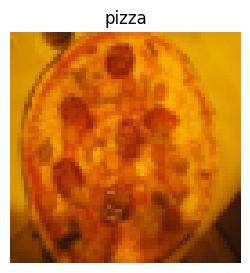

In [20]:
plt.figure(figsize=(3,3))
plt.axis(False)
plt.title(train_dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [21]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=16
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    shuffle=True,
)

In [22]:
len(train_dataloader), len(test_dataloader)

(15, 75)

## Create Models

In [23]:
import torch
from torch import nn
from helper_functions import accuracy_fn, plot_loss_curves, PytorchModelTranier

CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)
HIDDEN_UNITS = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Model 0: Base Model using simple linear layers

In [58]:
model = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(out_features=1000),
    nn.LazyLinear(out_features=100),
    nn.Linear(in_features=100, out_features=NUM_CLASSES)
).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.1,
)

model_0_trainer = PytorchModelTranier(
    name="v0-baseline-model",
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    logits_to_pred=lambda logits: torch.softmax(logits, dim=1).argmax(dim=1)
)

In [59]:
it = iter(train_dataloader)

In [73]:
img_batch, label_batch = next(it)
# img_batch, label_batch
y_logits = model(img_batch)
loss = loss_fn(y_logits, label_batch)
optimizer.zero_grad()
loss.backward()
optimizer.step()

loss
# y_logits

tensor(nan, grad_fn=<NllLossBackward0>)

 20%|██        | 1/5 [00:01<00:06,  1.67s/it]

Epoch 1/5 Train Loss: nan | Train Acc: 34.17% Test Loss: nan | Test Acc: 33.33%


 40%|████      | 2/5 [00:03<00:04,  1.55s/it]

Epoch 2/5 Train Loss: nan | Train Acc: 32.50% Test Loss: nan | Test Acc: 33.33%


 60%|██████    | 3/5 [00:04<00:03,  1.54s/it]

Epoch 3/5 Train Loss: nan | Train Acc: 32.50% Test Loss: nan | Test Acc: 33.33%


 80%|████████  | 4/5 [00:06<00:01,  1.52s/it]

Epoch 4/5 Train Loss: nan | Train Acc: 38.75% Test Loss: nan | Test Acc: 33.33%


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]

Epoch 5/5 Train Loss: nan | Train Acc: 32.50% Test Loss: nan | Test Acc: 33.33%


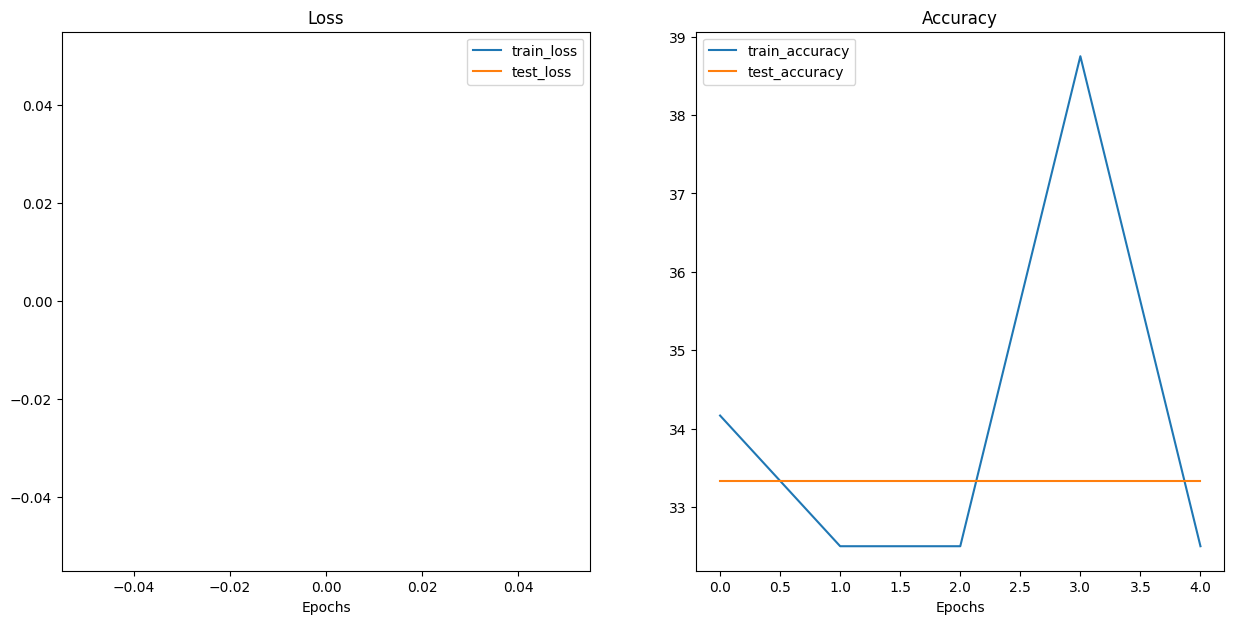

In [26]:
model_0_trainer.train(5)
model_0_trainer.plot_losses()